# irisデータを使ってSHAPを使ってみる

このノートブックでは、SHAP値により特徴量が予測へどのように影響しているかを見てみる。


## SHAP値とは

SHAP値とは、データセット中の各特徴量が予測結果にどれだけ影響を与えたか、その寄与度を表現したもの。この値を用いることで、ある特徴量の増減が予測に与える影響を可視化できる。

## feature importanceとはどう違うのか

- どの説明変数の影響が大きいか？・・・feature importance
- 予測結果に対して説明変数の寄与度は？・・・SHAP

モデル作成時点での影響を見るのがfeature importanceで、学習済みモデルを使って算出するのがSHAP。

feature importanceは一貫性（「consistency」と書かれる場合が多い）が**ない**のが特徴で、決定木のモデルを変える（決定木のノードで使う説明変数を変更）と、それまでのimportanceと異なる結果が出ることがある。

![pic](./20200607_inconsistency.png)

SHAPはこういった一貫性の齟齬が起きないのがポイント。

## 可視化方法

予測結果への影響を可視化するためには、SHAP値を算出する必要がある。ここではPythonライブラリの`shap`を用いて算出および可視化を行う。

![pic](./20200607_shapexplanation.png)

## 可視化手順

1. 任意のアルゴリズムによる学習済みモデルを用意する。
1. `shap`の`Explainer`に学習済みモデルを渡してSHAPモデルを作成する。
1. SHAPモデルの`shap_values`メソッドに予測用の説明変数を渡してSHAP値を取得する。
1. 得られたSHAP値から`force_plot`などにより可視化を行う。

## インストール

```console
pip install shap
```

Anaconda環境下では下記のコマンドでインストール可能。

```console
conda install -c conda-forge shap
```

なお、`tqdm`の[アップデートが必要である場合がある](https://github.com/nteract/papermill/issues/287)ので注意。

## 環境

- python 3.7.5
- shap 0.35.0


In [1]:
# ライブラリのインポート
import shap  
import pandas as pd  
from sklearn.ensemble import RandomForestClassifier  
from sklearn.datasets import load_iris 

In [2]:
# irisデータのロード
iris = load_iris()  
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names) 

In [3]:
rfc = RandomForestClassifier().fit(iris_df, iris.target)

In [4]:
# shapモデル作成のためExplainerに学習済みモデルを渡す
explainer = shap.TreeExplainer(rfc)  

## SHAPモデルを作成する

SHAPモデルとはshapによる可視化を行うために必要な、shap算出のためのクラス。このクラスの作成には、`shap`ライブラリの`Explainers`機能と利用する。この機能を利用する場合は、学習モデルのアルゴリズムによりSHAPモデル作成の際に呼び出すメソッドが異なるので注意が必要。下記ではランダムフォレストを利用しているため、`TreeExplainer`を利用している。その他、ディープラーニングによる学習モデル用に用意された`DeepExplainer`などがある。

詳しくは[オフィシャルドキュメント](https://shap.readthedocs.io/en/latest/)を参照。


## force_plot

横棒のグラフで、ある説明変数を与えたときに予測結果と結果における説明変数の寄与度を可視化する。

例えば、irisデータの1つ目を説明変数として渡すと、0(=setosa)、1(=versicolor)、2(=virginica)のうちどのクラスで予測されるか、どの説明変数がどのくらい予測に影響を与えているかが確認できる。

In [5]:
# 予測用の説明変数を渡してSHAP値を得る
pred_data = iris_df.loc[[0]]  

shap_values_force = explainer.shap_values(pred_data)  


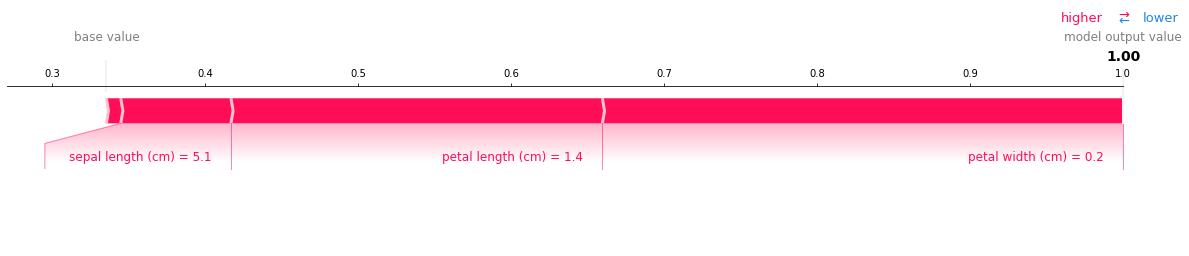

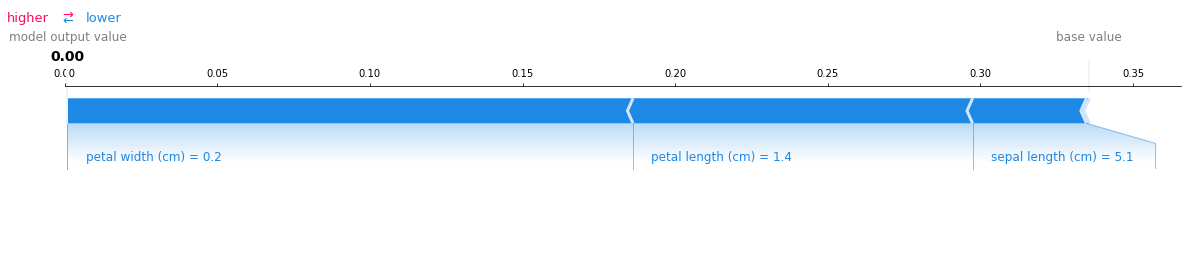

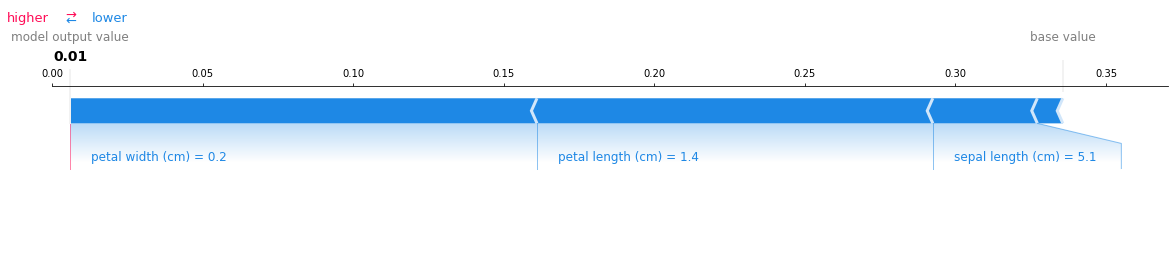

In [6]:
# force_plotでクラス0、1、2のどれでどのくらい説明変数が影響を与えているかを可視化する
for i in range(3):  
    shap.force_plot(explainer.expected_value[0], shap_values_force[i], pred_data, matplotlib=True)

## dependence_plot

`dependence_plot`では、対象のクラスに対して各説明変数の値とSHAP値の関係を可視化する。

たとえば、irisのクラス0について各説明変数の値の大小により、SHAP値がどのように変化しているかを見ることができる（SHAP値が大きいほど予測に影響を大きく及ぼす）。

In [7]:
iris_df.columns

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)'],
      dtype='object')

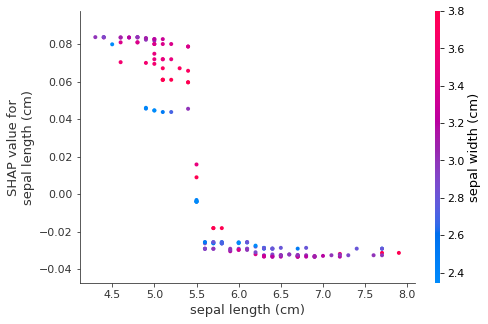

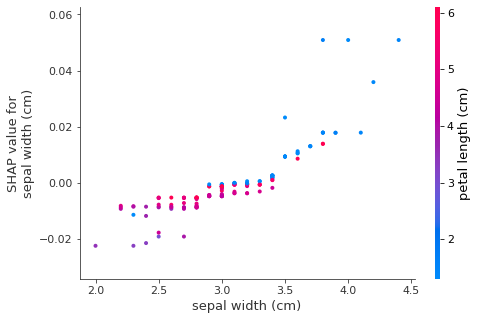

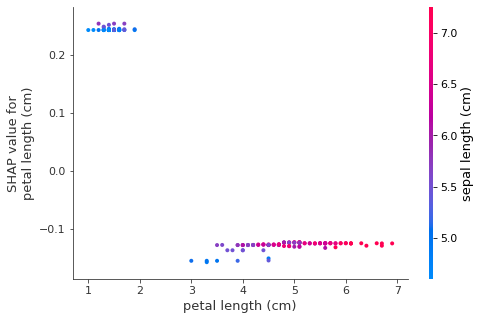

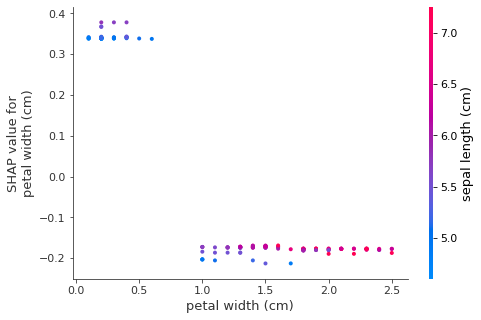

In [8]:
shap_values_dep = explainer.shap_values(iris_df)

for col in iris_df.columns.tolist():
    shap.dependence_plot(col, shap_values_dep[0], features=iris_df)

上記を見ると、クラス0についてはsepal widthが大きいほどSHAP値がマイナスになる。つまり、クラス0という予測結果に対する影響が小さくなる。逆にsepal lengthは値が大きくなるほどSHAP値も増加する。ただし、最大のSHAP値でも0.03なので、この説明変数そのものは予測結果に大きく影響していない。大きく影響を及ぼしているのはpetal lengthとpetal widthの2つで、それぞれ値が小さいほどSHAP値が大きくなっている。つまり、クラス0という予測結果において大きく影響を与えている項目と解釈できる。


## summary_plot

説明変数がそれぞれの予測結果に対してどの程度影響を与えているか、SHAP値で確認できる。出力は横の棒グラフ（デフォルト）の他、相関関係を確認できるドットでの出力やバイオリンプロットでの出力も可能。その際はクラスを指定し、オプションで出力形式を指定する（マルチクラスの出力はデフォルトの棒グラフのみ可能）。

In [9]:
iris.target_names.tolist()

['setosa', 'versicolor', 'virginica']

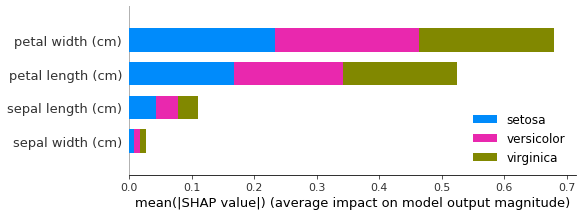

In [10]:
shap_values_sum = explainer.shap_values(iris_df)

# 棒グラフでの出力
shap.summary_plot(shap_values_sum, features=iris_df, class_names=iris.target_names.tolist())

上記の実行結果から、どのクラスを予測する場合でもpetal widthとpetal lengthの2つが結果に大きく影響を及ぼしているのがわかる。

ドットプロットにより、各説明変数とSHAP値の相関関係を見る。横軸がSHAP値の大小を表している。縦軸の説明変数についてその値の大小（カラーバーで示されている）が、ある予測結果におけるSHAP値とどんな相関関係であるかを見る。

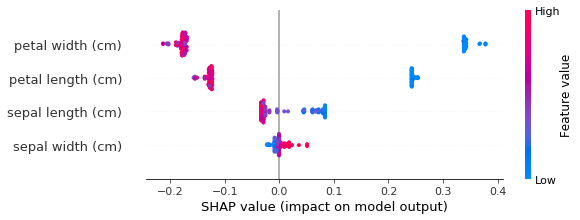

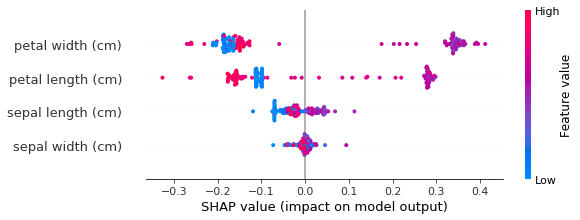

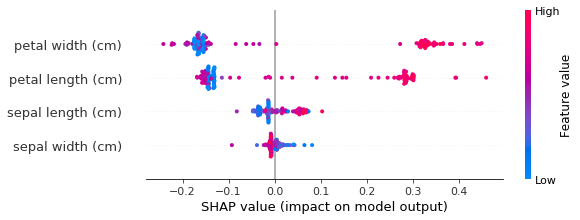

In [13]:
# 相関関係を確認する。下記はクラス0、1、2の予測結果に対するSHAP値を出力している。
for i in range(3):
    shap.summary_plot(shap_values_sum[i], features=iris_df, plot_type='dot')

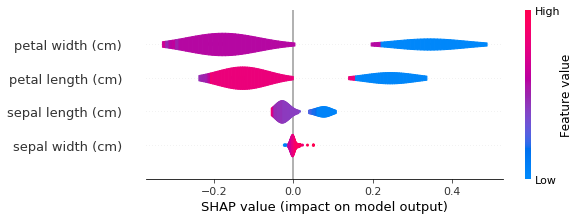

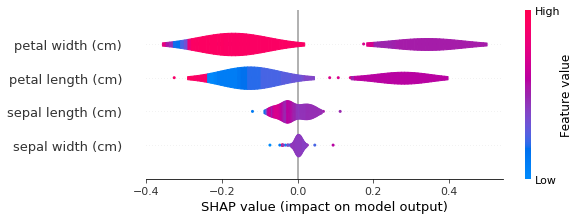

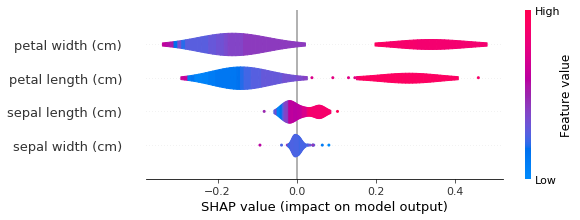

In [14]:
for i in range(3):
    shap.summary_plot(shap_values_sum[i], features=iris_df, plot_type='violin')

## image_plot（参考）

`image_plot`は画像データを対象に、SHAP値の可視化を行う。画像のどの箇所が予測結果に影響を及ぼしているかが、カラーバーによる出力で確認できる。

![pic](./20200607_imageplot.png)

この画像だと、VGG16※には「木」ではなく「車」と認識されてしまう。`image_plot`に見てみると、右図の左下あたりに車のような形状を認識（誤認識）していることがわかり、なぜ誤ったのかを読み取れる。

※VGG16・・・「ImageNet」と呼ばれる大規模画像データセットで学習された16層からなるCNNモデル

## 参考

[Consistent Individualized Feature Attribution for TreeEnsembles](https://arxiv.org/abs/1802.03888)

（[上記論文のメモページ](https://github.com/yoheikikuta/paper-reading/issues/17)）

[slundberg / shap](https://github.com/slundberg/shap)

[document](https://shap.readthedocs.io/en/latest/#)

[Shapを用いた機械学習モデルの解釈説明](https://qiita.com/shin_mura/items/cde01198552eda9146b7)

[機械学習モデルを解釈する指標SHAPについて](http://www.ie110704.net/2019/04/26/%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%83%A2%E3%83%87%E3%83%AB%E3%82%92%E8%A7%A3%E9%87%88%E3%81%99%E3%82%8B%E6%8C%87%E6%A8%99shap%E3%81%AB%E3%81%A4%E3%81%84%E3%81%A6/)

[SHAP値の考え方を理解する（木構造編）](https://www.slideshare.net/KazuyukiWakasugi/shap-181632545)

[SHAPの全メソッドを試してみた](https://own-search-and-study.xyz/2019/10/05/shap-all-methods/)
